<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Pro/HW2_Gradient_descent_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Домашнее задание: Градиентный спуск — продвинутая часть**

В этом домашнем задании вы ещё раз закрепите **градиентный спуск**, но уже в модифицированном виде.
Вы реализуете различные виды GD, закрепите на практике их свойства и улучшения и научитесь интерпретировать результаты.


**Дедлайн: 13 декабря 23:59**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler
import pandas as pd

np.random.seed(42)

### **Задание 1. Зоопарк оптимизаторов (5 баллов)**


Обычный градиентный спуск с постоянным шагом хорошо работает на простых выпуклых функциях, но резко теряет эффективность, как только ландшафт становится более сложным. В реальности ландшафт сложный всегда — если мы работаем с нейронной сетью — параметров много и функции сложные. В них есть разные проблемы (лучше, чем читать — посмотреть [здесь](https://losslandscape.com/gallery/)):

* узкие долины,
* сильно различающиеся масштабы по координатам,
* плоскости с почти нулевым градиентом,
* рябь, плоскости, седловые точки.

В таких ситуациях стандартный GD перестаёт справляться, поэтому в современной оптимизации почти никогда не используют голый вариант GD. Его заменяют **модифицированные методы**, которые:

* адаптируют шаг обучения под каждую координату,
* сглаживают траекторию накоплением информации о прошлых градиентах,
* корректируют скорость движения в зависимости от геометрии ландшафта.

В этом задании мы будем реализовывать такие методы в единой архитектуре.

#### **Задание 1.1 Реализация золотой пятерки (3 балла)**

Ниже в коде уже реализован общий базовый класс `Optimizer`, который:

* содержит цикл обучения (`fit`),
* считает градиенты,
* сохраняет историю оптимизации,
* контролирует количество итераций,
* передаёт параметры в оптимизатор.

Ваша задача, для каждого типа оптимизатора, реализовать метод:

```python
def step(self, params, gradient, iteration):
    ...
```

Он принимает, текущие параметры, текущий градиент, номер итерации и должен вернуть обновлённые параметры.


#### **Золотая пятерка**

0. **Vanilla Gradient Descent**
   $$w_{t+1} = w_t - \eta\nabla L(w_t)$$
   
   где $\eta$ — шаг обучения, $\nabla L(w_t)$ — градиент в точке $w_t$.

1. **Momentum (градиентный спуск с моментом)** —  накапливаем “скорость” (усреднённый градиент), чтобы сгладить траекторию и ускориться вдоль долины.
  $$v_t = \beta v_{t-1} + (1 - \beta)\nabla L(w_t)$$
  $$w_{t+1} = w_t - \eta v_t$$
   где $v_t$ — скорость, $\beta \in [0,1)$ — коэффициент затухания (часто 0.9).

2. **Nesterov Accelerated Gradient (NAG, ускоренный градиент Нестерова)** —  градиент вычисляется в точке, куда мы *ещё только собираемся сделать шаг*.

  $$v_t = \beta v_{t-1} + (1 - \beta) \nabla L(w_t)$$
  $$w_{t+1} = w_t - \eta \left( \beta v_t + (1 - \beta)\nabla L(w_t) \right)$$

3. **AdaGrad** — реализует адаптивный шаг обучения на основе накопления квадратов градиента. Идея такая — ксли по некоторой координате градиенты большие — по ней уменьшать шаг, а если градиенты маленькие → шаг остаётся большим.

$$G_t = G_{t-1} + (\nabla L(w_t))^2$$
$$\eta_t = \frac{\eta}{\sqrt{G_t+\varepsilon}}$$
$$w_{t+1} = w_t - \eta_t \nabla L(w_t)$$

где $\varepsilon$ — стабилизация — чтобы не делить на ноль.


4. **RMSprop** — экспоненциальное сглаживание квадратов градиента. Идея тут — убить недостаток AdaGrad —  онслишком быстро уменьшает шаг, поэтому RMSprop заменяет сумму экспоненциальным средним.

$$s_t = \beta s_{t-1} + (1 - \beta)(\nabla L(w_t))^2$$
$$\eta_t = \frac{\eta}{\sqrt{s_t + \varepsilon}}$$
$$w_{t+1} = w_t - \eta_t \nabla L(w_t)$$


5. **Adam** — Momentum + RMSprop одновременно. Идейно Adam поддерживает две экспоненциальные скользящие средние:

* $m_t$ — среднее градиентов (как momentum),
* $v_t$ — среднее квадратов градиентов (как RMSprop).

Кроме того, вводится коррекция смещения.

$$m_t = \beta_1 m_{t-1} + (1 - \beta_1)\nabla L(w_t)$$
$$v_t = \beta_2 v_{t-1} + (1 - \beta_2)(\nabla L(w_t))^2$$

$$\hat m_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat v_t = \frac{v_t}{1 - \beta_2^t}$$

$$w_{t+1} = w_t - \eta \frac{\hat m_t}{\sqrt{\hat v_t + \varepsilon}}$$



**Для каждого оптимизатора вы должны написать класс, наследуемый от `Optimizer`, и в нем метод `step()` ровно по формулам выше.
Без внешних библиотек, никаких упрощений. При этом:**


* Базовый класс `Optimizer` уже полностью готов, но в нем <font color="red">специально допущено несколько ошибок. Исправьте их.</font>
* Далее ваша задача — лишь реализовать формулы обновления весов в соответствующих классах.
* После реализации протестируйте оптимизаторы (это будет следующее задание).

In [2]:
class Optimizer:
    """Базовый класс для оптимизаторов"""

    def __init__(self, learning_rate=0.01, n_iterations=100):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.history = {
            'params': [],
            'loss': [],
            'gradients': []
        }

    def step(self, params, gradient, iteration):
        """Один шаг оптимизации - должен быть переопределён"""
        raise NotImplementedError

    def fit(self, loss_fn, grad_fn, initial_params):
        params = initial_params.copy()

        for i in range(self.n_iterations):
            gradient = grad_fn(params)

            # self.history['params'].append(initial_params.copy())
            self.history['params'].append(params.copy())    # берем актуальные параметры
            # self.history['loss'].append(loss_fn(initial_params))
            self.history['loss'].append(loss_fn(params))    # берем актуальные параметры
            self.history['gradients'].append(gradient.copy())

            params = self.step(params, gradient, i)

        self.history['params'].append(params.copy())
        # self.history['loss'].append(grad_fn(params))
        self.history['loss'].append(loss_fn(params))    # Ранее сохраняли loss
        self.history['gradients'].append(grad_fn(params))

        return params


class VanillaGD(Optimizer):
    """Обычный градиентный спуск"""

    def step(self, params, gradient, iteration):
        # Здесь мы просто вычитаем градиент, умноженный на величину шага
        return params - self.learning_rate*gradient


class MomentumGD(Optimizer):
    """GD с momentum"""

    def __init__(self, learning_rate=0.01, n_iterations=100, beta=0.9):
        super().__init__(learning_rate, n_iterations)
        self.beta = beta
        self.velocity = None

    def step(self, params, gradient, iteration):
        # Начальная скорость нулевая
        if self.velocity is None:
            self.velocity = np.zeros_like(gradient)

        self.velocity = self.beta*self.velocity + (1-self.beta)*gradient
        return params - self.learning_rate*self.velocity


class NesterovGD(Optimizer):
    """Nesterov Accelerated Gradient"""

    def __init__(self, learning_rate=0.01, n_iterations=100, beta=0.9):
        super().__init__(learning_rate, n_iterations)
        self.beta = beta
        self.velocity = None

    def step(self, params, gradient, iteration):
        # Начальная скорость нулевая
        if self.velocity is None:
            self.velocity = np.zeros_like(gradient)

        self.velocity = self.beta*self.velocity + (1-self.beta)*gradient
        return params - self.learning_rate * (self.beta*self.velocity + (1-self.beta)*gradient)


class AdaGrad(Optimizer):
    """AdaGrad optimizer"""

    def __init__(self, learning_rate=0.01, n_iterations=100, epsilon=1e-8):
        super().__init__(learning_rate, n_iterations)
        self.epsilon = epsilon
        self.accumulated_grad = None

    def step(self, params, gradient, iteration):
        # Начальный накопленный градиент нулевой
        if self.accumulated_grad is None:
            self.accumulated_grad = np.zeros_like(gradient)
        
        self.accumulated_grad = self.accumulated_grad + gradient**2
        learning_rate = self.learning_rate/np.sqrt(self.accumulated_grad + self.epsilon)
        return params - learning_rate*gradient

class RMSprop(Optimizer):
    """RMSprop optimizer"""

    def __init__(self, learning_rate=0.01, n_iterations=100, beta=0.9, epsilon=1e-8):
        super().__init__(learning_rate, n_iterations)
        self.beta = beta
        self.epsilon = epsilon
        self.squared_grad = None

    def step(self, params, gradient, iteration):
        # Начальный накопленный градиент нулевой
        if self.squared_grad is None:
            self.squared_grad = np.zeros_like(gradient)
        
        self.squared_grad = self.beta*self.squared_grad + (1-self.beta)*gradient**2
        learning_rate = self.learning_rate/np.sqrt(self.squared_grad + self.epsilon)
        return params - learning_rate*gradient


class Adam(Optimizer):
    """Adam optimizer"""

    def __init__(self, learning_rate=0.01, n_iterations=100, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(learning_rate, n_iterations)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None

    def step(self, params, gradient, iteration):
        # Начальные скользящие нулевые
        if self.m is None:
            self.m = np.zeros_like(gradient)
            self.v = np.zeros_like(gradient)

        self.m = self.beta1*self.m + (1-self.beta1)*gradient
        self.v = self.beta2*self.v + (1-self.beta2)*gradient**2

        # Скользащие с крышечками (несмещенные)
        m_hat = self.m/(1-self.beta1**(iteration+1))
        v_hat = self.v/(1-self.beta2**(iteration+1))

        return params - self.learning_rate*m_hat/np.sqrt(v_hat+self.epsilon)


#### **Задание 1.2 Тестирование золотой пятерки (2 балла)**

Протестируем оптимизиторы на красивой двумерной функции — **функции Растригина (Rastrigin function)**. Почему именно она? На самом деле, существует несколько [популярных функций-тестов](https://en.wikipedia.org/wiki/Test_functions_for_optimization) для функций оптимизации. И все они безумно красивые. Просто эта — [особенно хорошо отражает сложные ландшафты](https://en.wikipedia.org/wiki/Rastrigin_function). Она имеет:

* большое число локальных экстремумов,
* регулярную рябь по всей области,
* хорошо выраженный глобальный минимум.

Её аналитическая форма в двумерном случае:

$$f(x, y) = 20 + x^2 + y^2 - 10(\cos(2\pi x) + \cos(2\pi y))$$

Глобальный минимум:

$$(x^*, y^*) = (0,0), \quad f(x^*, y^*) = 0.$$


**Что сделать в задании:**
1. Реализовать функцию (двумерную) и ее градиент

2. Запустить каждый оптимизатор:

   * записать функцию и её градиент;
   * запустить оптимизиторы из данной стартовой точки (она прописана в коде), с прописанным базовым learning rate.

3. Для каждого метода вывести:

   * итоговые значения аргументов $x$ и $y$,
   * финальное значение функции потерь.


4. Сделать краткий анализ. Можно опираться на вопросы:

   * Какие методы сходятся быстрее?
   * Кто застрял в локальных минимумах?
   * Насколько траектории “дрожат”?
   * Как адаптивные методы корректируют шаг?
   * Какие методы вышли ближе всего к глобальному минимуму?






In [3]:
def rastrigin_function(params, A=10.0):
    """
    Rastrigin function (2D).
    f(x, y) = 2A + x^2 - A cos(2πx) + y^2 - A cos(2πy)
    Глобальный минимум: (0, 0), f = 0.
    """
    x, y = params
    return 2*A + x**2 - A*np.cos(2*np.pi*x) + y**2 - A*np.cos(2*np.pi*y)


def rastrigin_gradient(params, A=10.0):
    """
    Gradient of Rastrigin function.
    ∂f/∂x = 2x + 2πA sin(2πx)
    ∂f/∂y = 2y + 2πA sin(2πy)
    """
    x, y = params
    dx = 2*x + 2*np.pi*A*np.sin(2*np.pi*x)
    dy = 2*y + 2*np.pi*A*np.sin(2*np.pi*y)
    return np.array([dx, dy])


# Параметры
initial_point = np.array([-1.0, 2.0])  # стартовая точка вдали от минимума — не меняем!
n_iter = 300

# Создаём оптимизаторы
optimizers = {
    'GD':       VanillaGD(learning_rate=0.05, n_iterations=n_iter),
    'Momentum': MomentumGD(learning_rate=0.05, n_iterations=n_iter, beta=0.9),
    'NAG':      NesterovGD(learning_rate=0.05, n_iterations=n_iter, beta=0.9),
    'AdaGrad':  AdaGrad(learning_rate=0.05,  n_iterations=n_iter),
    'RMSprop':  RMSprop(learning_rate=0.05,  n_iterations=n_iter, beta=0.9),
    'Adam':     Adam(learning_rate=0.05,     n_iterations=n_iter)
}

# Создаём сетку для визуализации
x_range = np.linspace(-5.5, 5.5, 300)
y_range = np.linspace(-5.5, 5.5, 300)
X, Y = np.meshgrid(x_range, y_range)
Z = np.zeros_like(X)

for i in range(len(x_range)):
    for j in range(len(y_range)):
        Z[j, i] = rastrigin_function(np.array([X[j, i], Y[j, i]]))

# Обучаем все оптимизаторы
results = {}
for name, optimizer in optimizers.items():
    final_params = optimizer.fit(rastrigin_function, rastrigin_gradient, initial_point)
    results[name] = optimizer.history
    print(f"{name:12s}: Final loss = {rastrigin_function(final_params):.6f}, "
          f"Params = [{final_params[0]:.4f}, {final_params[1]:.4f}]")

print(f"\nГлобальный минимум (True): [0, 0]")

# Визуализация траекторий — если вы ничего не меняли в базовом классе — оно просто запустится
fig_opt = go.Figure()

# Контур функции
fig_opt.add_trace(
    go.Contour(
        x=x_range,
        y=y_range,
        z=np.log10(Z + 1),  # лог по (f + 1), чтобы избежать log(0)
        colorscale='Viridis',
        showscale=False,
        contours=dict(start=0, end=3, size=0.1),
        opacity=0.6,
        name='Rastrigin function (log scale)'
    )
)

# Траектории всех оптимизаторов
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink']
for idx, (name, history) in enumerate(results.items()):
    trajectory = np.array(history['params'])
    fig_opt.add_trace(
        go.Scatter(
            x=trajectory[:, 0],
            y=trajectory[:, 1],
            mode='lines',
            line=dict(color=colors[idx], width=2),
            name=name
        )
    )

# Глобальный минимум
fig_opt.add_trace(
    go.Scatter(
        x=[0.0], y=[0.0],
        mode='markers',
        marker=dict(size=15, color='yellow', symbol='star',
                    line=dict(color='black', width=2)),
        name='Глобальный минимум'
    )
)

# Стартовая точка
fig_opt.add_trace(
    go.Scatter(
        x=[initial_point[0]], y=[initial_point[1]],
        mode='markers',
        marker=dict(size=10, color='red', symbol='x'),
        name='Старт'
    )
)

fig_opt.update_layout(
    title="Сравнение оптимизаторов на Rastrigin function",
    xaxis_title="x",
    yaxis_title="y",
    hovermode='closest',
    width=900,
    height=700
)

fig_opt.show()


GD          : Final loss = 88.151087, Params = [1.8663, -8.8893]
Momentum    : Final loss = 4.974790, Params = [-0.9950, 1.9899]
NAG         : Final loss = 17.908477, Params = [-1.1932, 2.1714]
AdaGrad     : Final loss = 4.974790, Params = [-0.9950, 1.9899]
RMSprop     : Final loss = 5.220721, Params = [-1.0199, 2.0148]
Adam        : Final loss = 4.974790, Params = [-0.9950, 1.9899]

Глобальный минимум (True): [0, 0]


**Ваш анализ здесь**
1. Чего не хватило адаптивным методам? Что с ними произошло?
2. Почему градиетному спуску так плохо?

**Выводы:**
1. Адаптивным методам не хватило накопленных моментов/скорости/импульса либо размера шага для преодоления локального минимума (ямы). В итоге все застряли в локальном минимуме, но при этом быстро сошлись
2. Для классического градиентного спуска без модификаций шаг оказался слишком большим и оптимизатор хаотично перепрыгивал минимумы, в том числе глобальный. Его траектория сильно дрожит.
3. С заданными гиперпараметрами ни один оптимизатор не нашел глобальный минимум.

### **Задание 2. Анализ Losses (2 балла)**



В реализации базового класса `Optimizer`, при каждом спуске сохраняются графики loss-функции. Их в процессе обучения мы также анализируем. Напомним, что говорят, что **loss “сходится”**, если выполняются следующие признаки:

1. Значение loss $L(w_k)$ монотонно убывает и приближается к некоторому предельному значению (выходит на плато):
   $$|L(w_{k+1}) - L(w_k)| \to 0$$

Сошелся ли лосс у нас? Используйте ваши реализации из заданий 1–2:

1. Постройте графики значения loss, проанализируйте, какие спуски сошлись.
2. Поизменяйте learning rate, обучите спуски ещё и снова выведите лосс. Как learning rate влияет на результат и удалось ли сойтись теперь?

In [ ]:
def plot_losses_all(optimizers: dict):

    # Построим все графики loss на одном полотне
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    axes = axes.flatten()

    # Сделаем графики разными цветами
    colors = plt.cm.tab10(np.linspace(0, 1, len(optimizers)))

    # Цвет для минимума значения loss
    min_color = 'red'

    for ax, (name, optimizer), color in zip(axes, optimizers.items(), colors):
        loss = optimizer.history['loss']
        min_loss = min(loss)

        # График loss
        loss_line, = ax.plot(loss, label='Loss', color=color, linewidth=2)

        # Добавим линию минимума loss
        min_line = ax.axhline(
            y=min_loss,
            linestyle='--',
            linewidth=1.8,
            color=min_color,
            alpha=0.8,
            label=f'Min loss {min_loss:.4f}',
        )

        ax.set_title(name, fontsize=12)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Loss')
        #ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
        ax.legend(handles=[loss_line, min_line], fontsize=8)

    fig.suptitle(f'Losses for learning rate {optimizer.learning_rate}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

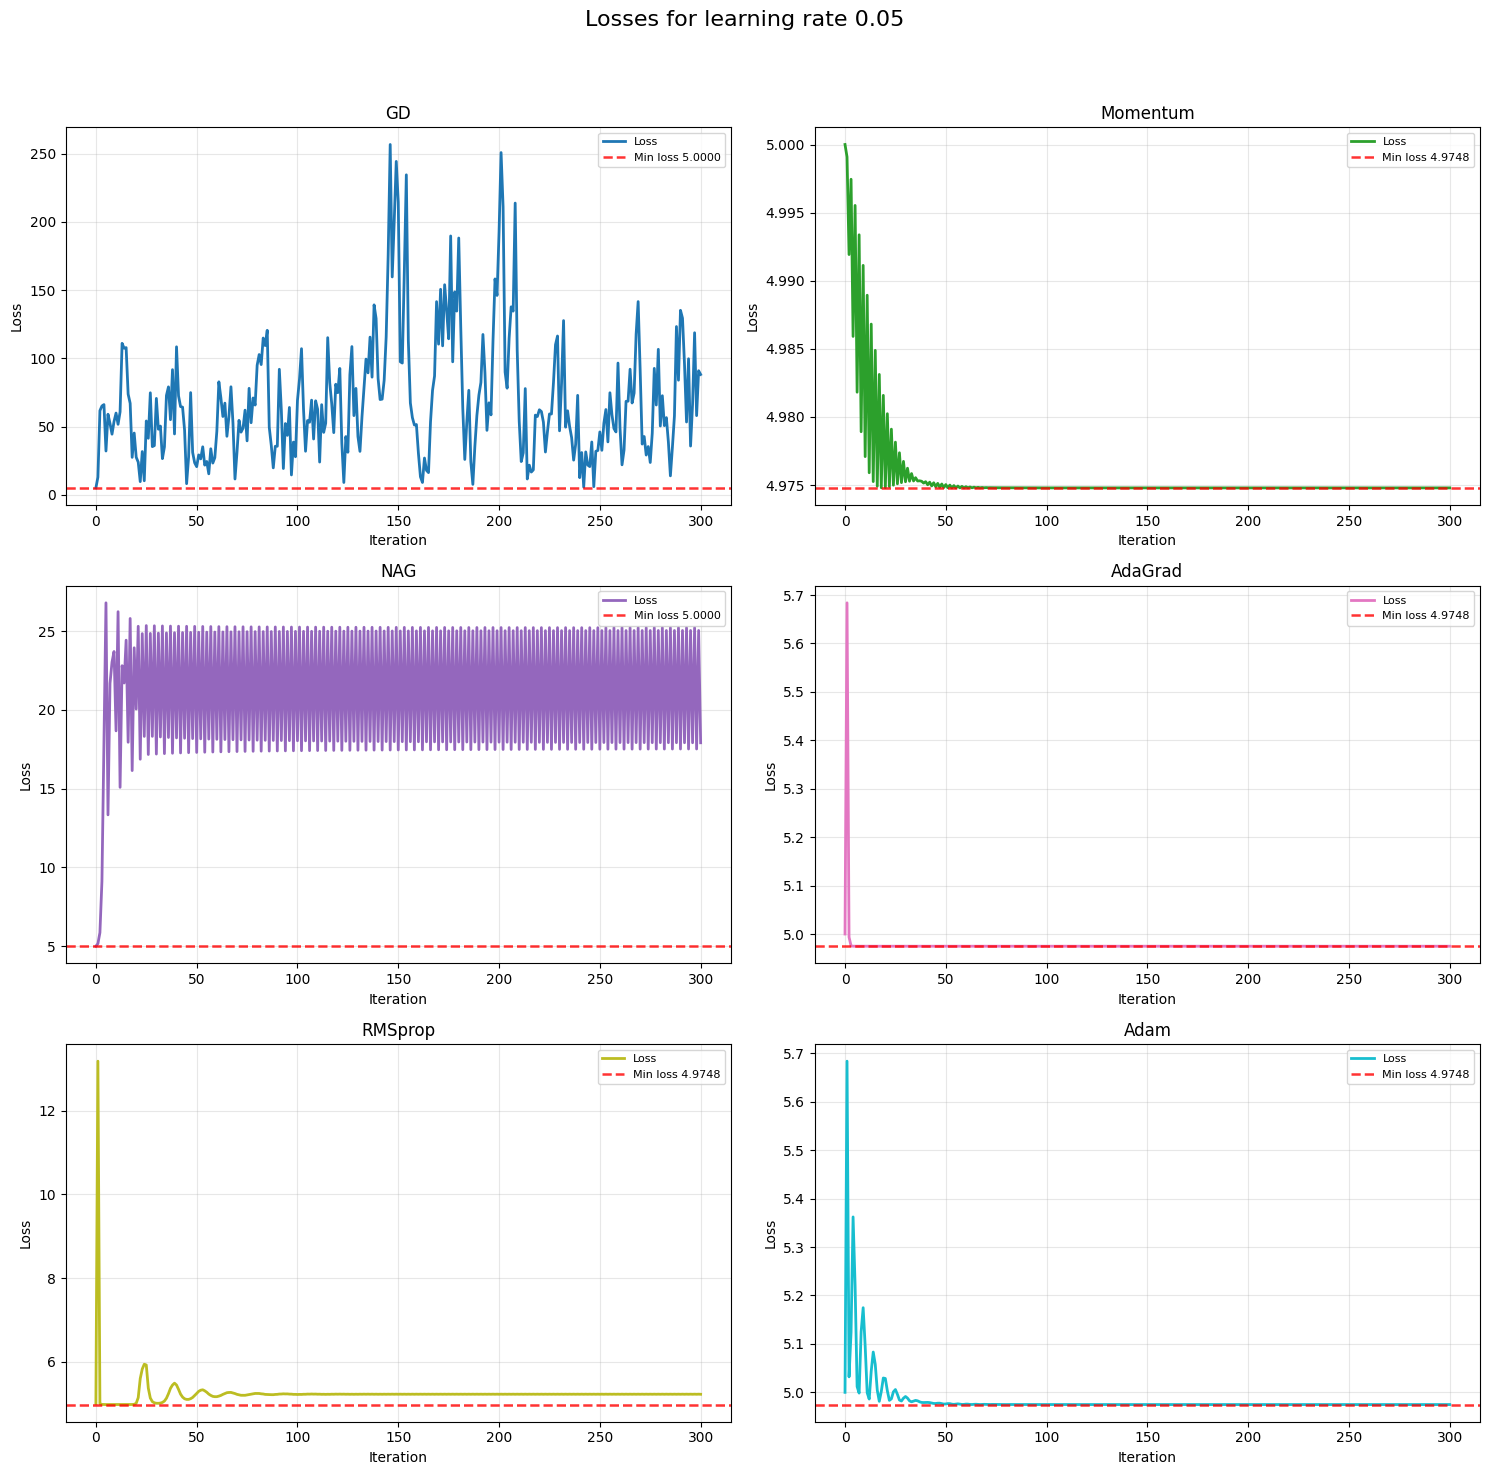

In [63]:
plot_losses_all(optimizers)

**Выводы:**
- по графикам видно, что momentum, AdaGrad, RMSprp и Adam сошлись
- NAG ушел от минимума и гарминически колеблется в диапазоне
- GD сильно осциллирует, к минимуму не сошолся

In [68]:
def run_experiment_with_lr(lr: float):
    
    # Параметры
    initial_point = np.array([-1.0, 2.0])  # стартовая точка вдали от минимума — не меняем!
    n_iter = 300

    # Создаём оптимизаторы
    optimizers = {
        'GD':       VanillaGD(learning_rate=lr, n_iterations=n_iter),
        'Momentum': MomentumGD(learning_rate=lr, n_iterations=n_iter, beta=0.9),
        'NAG':      NesterovGD(learning_rate=lr, n_iterations=n_iter, beta=0.9),
        'AdaGrad':  AdaGrad(learning_rate=lr,  n_iterations=n_iter),
        'RMSprop':  RMSprop(learning_rate=lr,  n_iterations=n_iter, beta=0.9),
        'Adam':     Adam(learning_rate=lr,     n_iterations=n_iter)
    }

    print(f'learning rate: {lr}')

    # Обучаем все оптимизаторы
    results = {}
    for name, optimizer in optimizers.items():
        final_params = optimizer.fit(rastrigin_function, rastrigin_gradient, initial_point)
        results[name] = optimizer.history
        print(f"{name:12s}: Final loss = {rastrigin_function(final_params):.6f}, "
            f"Params = [{final_params[0]:.4f}, {final_params[1]:.4f}]")

    plot_losses_all(optimizers)

    return optimizers

learning rate: 0.01
GD          : Final loss = 22.872699, Params = [-0.9783, 2.3577]
Momentum    : Final loss = 4.974790, Params = [-0.9950, 1.9899]
NAG         : Final loss = 4.974790, Params = [-0.9950, 1.9899]
AdaGrad     : Final loss = 4.974790, Params = [-0.9950, 1.9899]
RMSprop     : Final loss = 4.984687, Params = [-1.0000, 1.9949]
Adam        : Final loss = 4.974790, Params = [-0.9950, 1.9899]


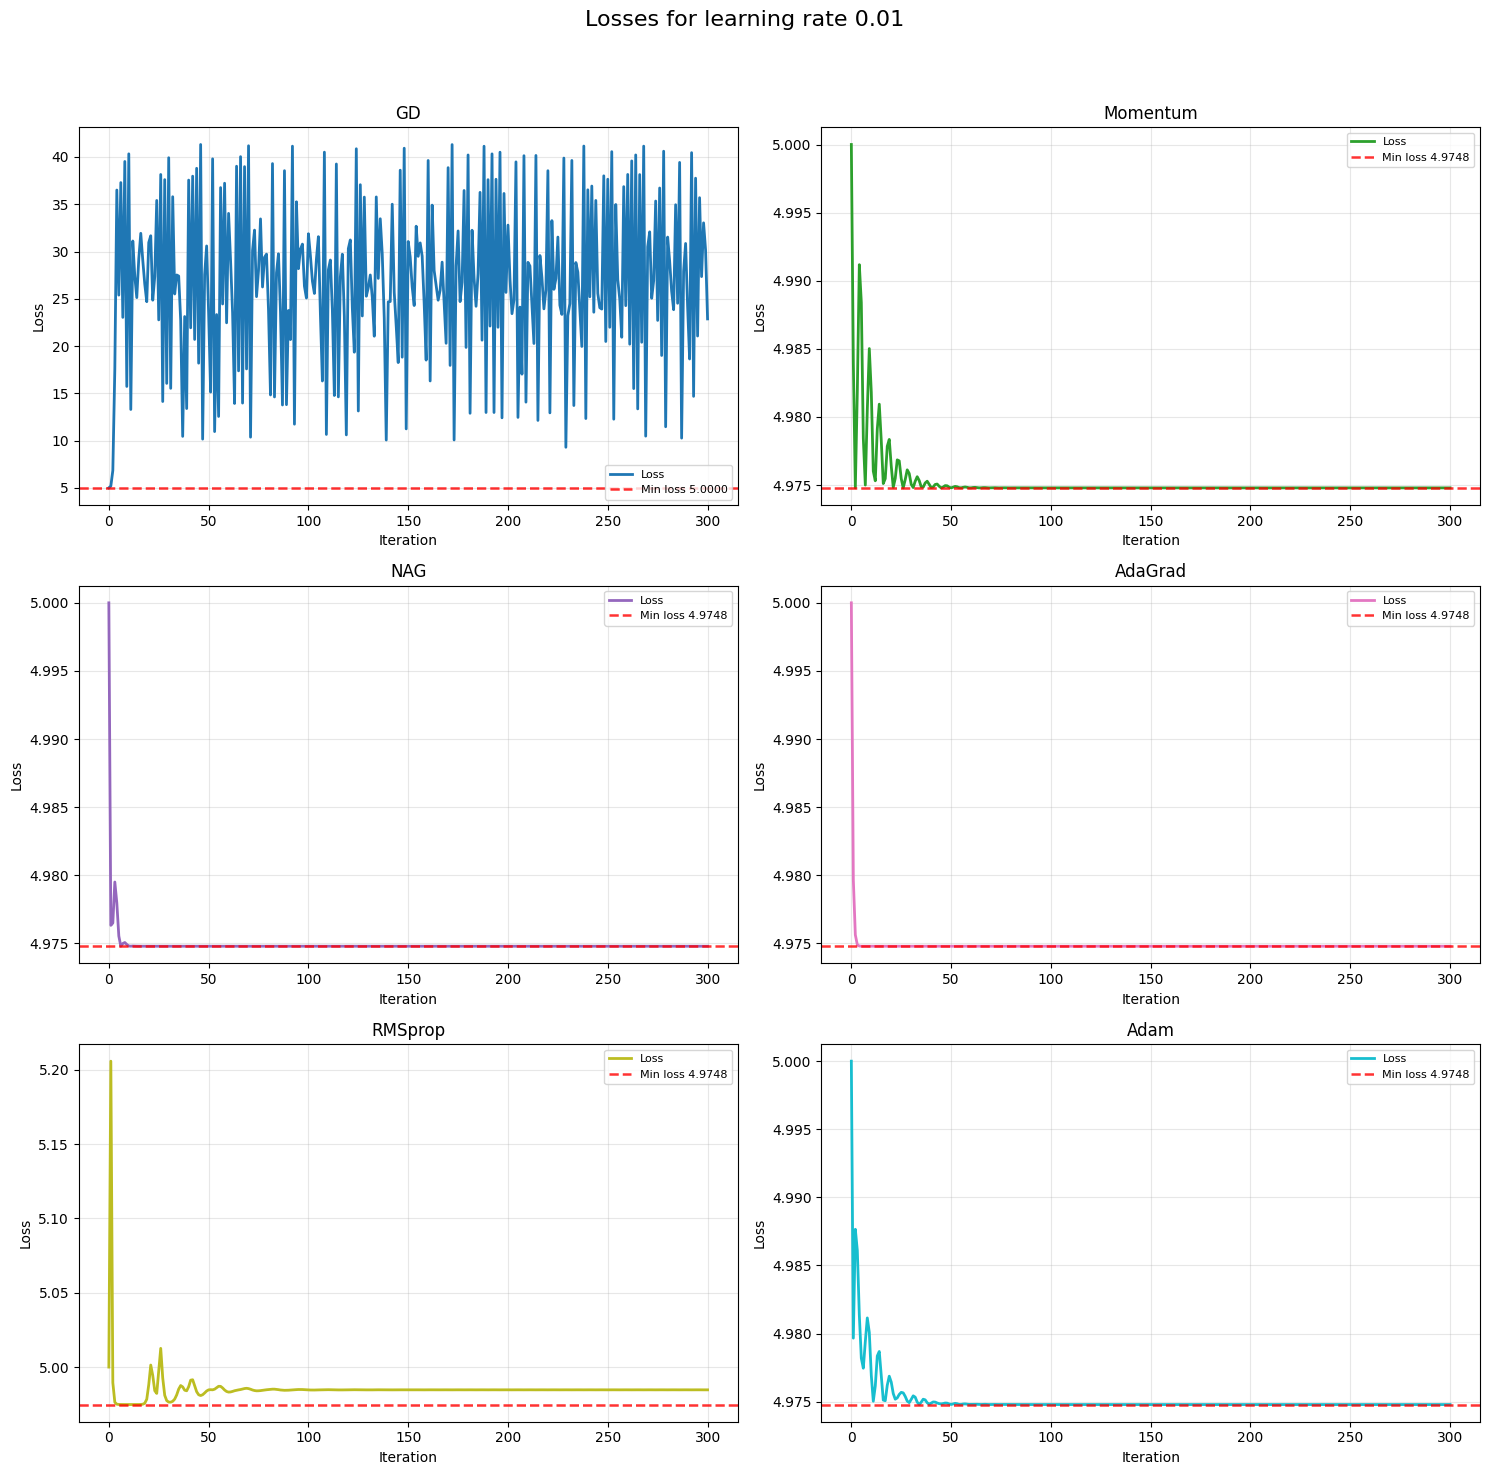

learning rate: 0.05
GD          : Final loss = 88.151087, Params = [1.8663, -8.8893]
Momentum    : Final loss = 4.974790, Params = [-0.9950, 1.9899]
NAG         : Final loss = 17.908477, Params = [-1.1932, 2.1714]
AdaGrad     : Final loss = 4.974790, Params = [-0.9950, 1.9899]
RMSprop     : Final loss = 5.220721, Params = [-1.0199, 2.0148]
Adam        : Final loss = 4.974790, Params = [-0.9950, 1.9899]


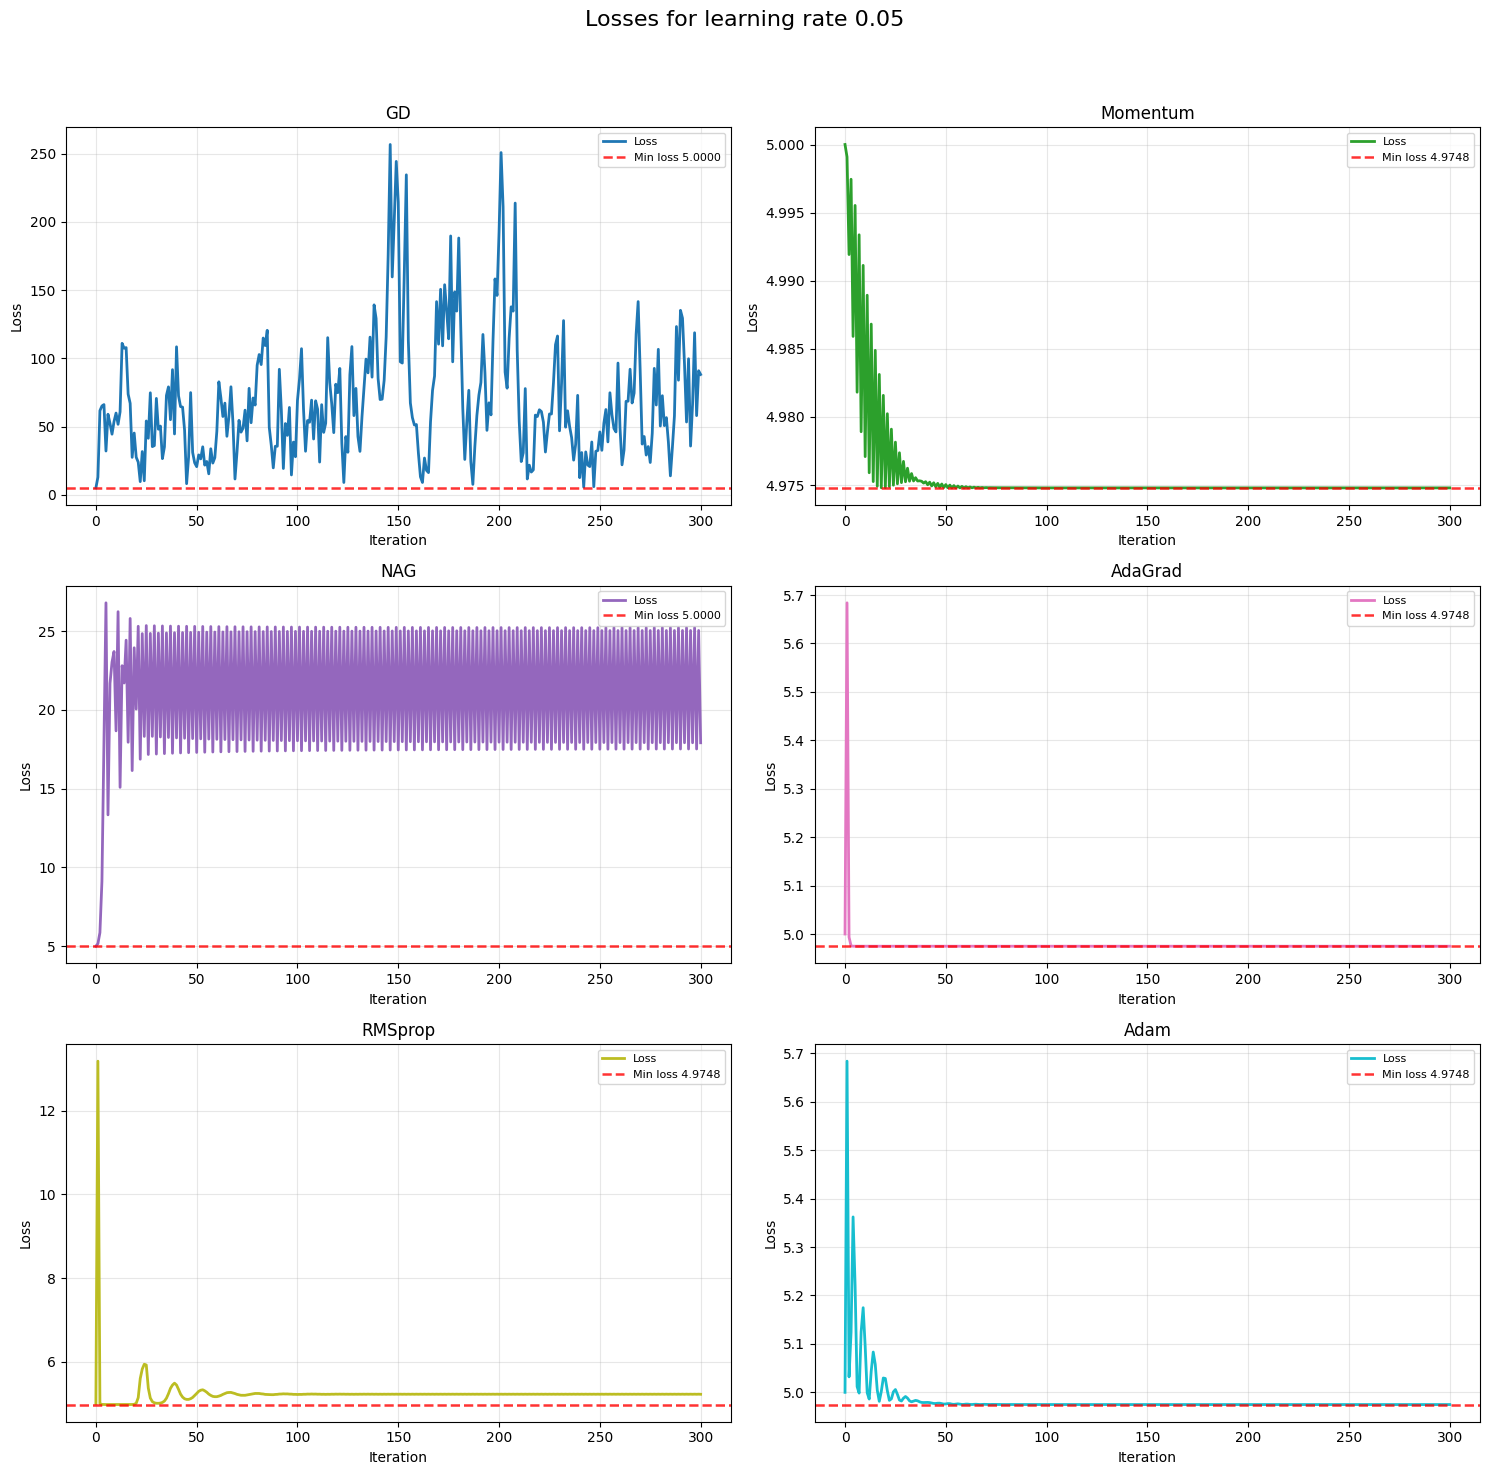

learning rate: 0.1
GD          : Final loss = 248.672193, Params = [-13.1330, 8.1834]
Momentum    : Final loss = 7.378101, Params = [-1.0745, 2.0670]
NAG         : Final loss = 66.313421, Params = [-5.2102, -3.4592]
AdaGrad     : Final loss = 4.974790, Params = [-0.9950, 1.9899]
RMSprop     : Final loss = 5.947148, Params = [-1.0447, 2.0394]
Adam        : Final loss = 4.974790, Params = [-0.9950, 1.9899]


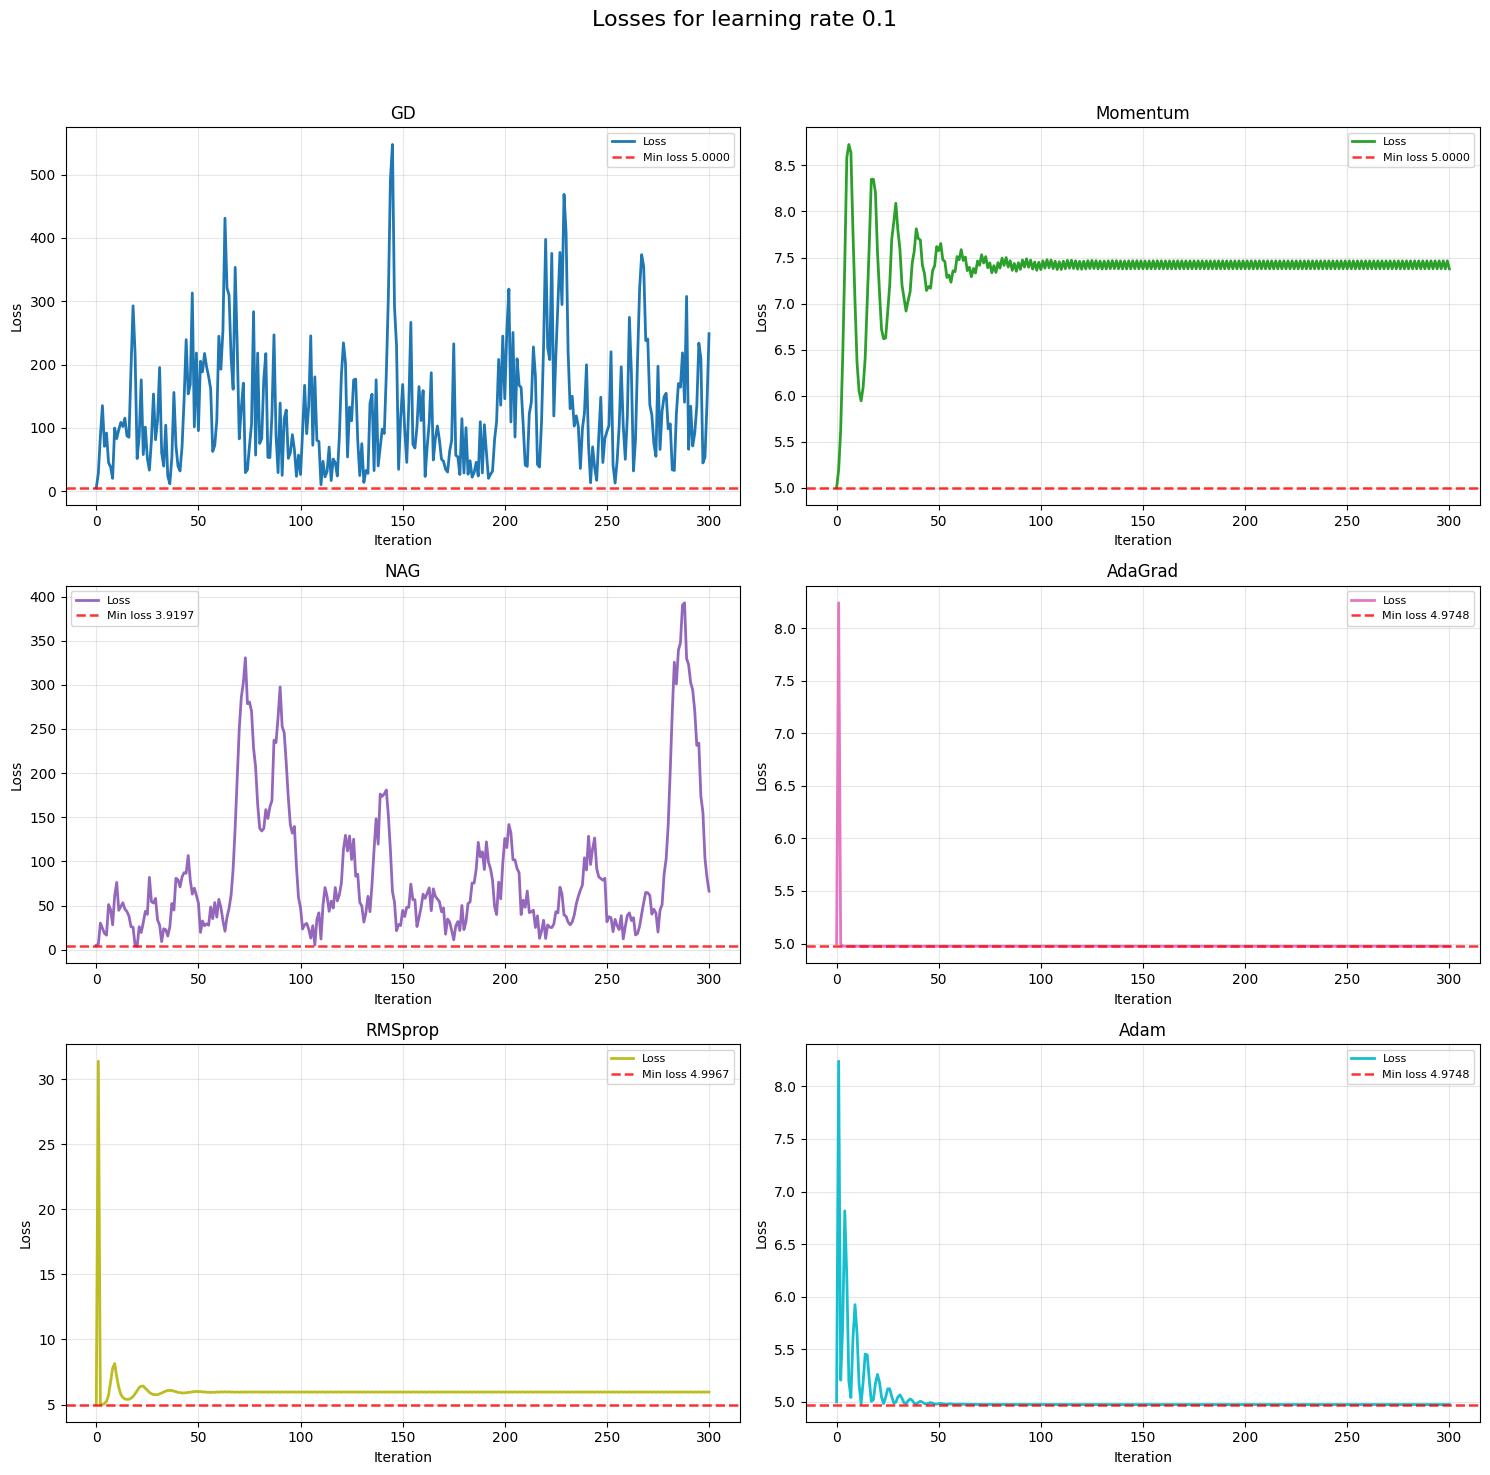

learning rate: 0.5
GD          : Final loss = 1667.287210, Params = [-28.4781, 28.7901]
Momentum    : Final loss = 625.134591, Params = [5.5982, 23.9922]
NAG         : Final loss = 416.778504, Params = [18.2768, 7.3683]
AdaGrad     : Final loss = 0.994959, Params = [-0.0000, 0.9950]
RMSprop     : Final loss = 38.034295, Params = [1.6544, 0.4469]
Adam        : Final loss = 0.000000, Params = [0.0000, -0.0000]


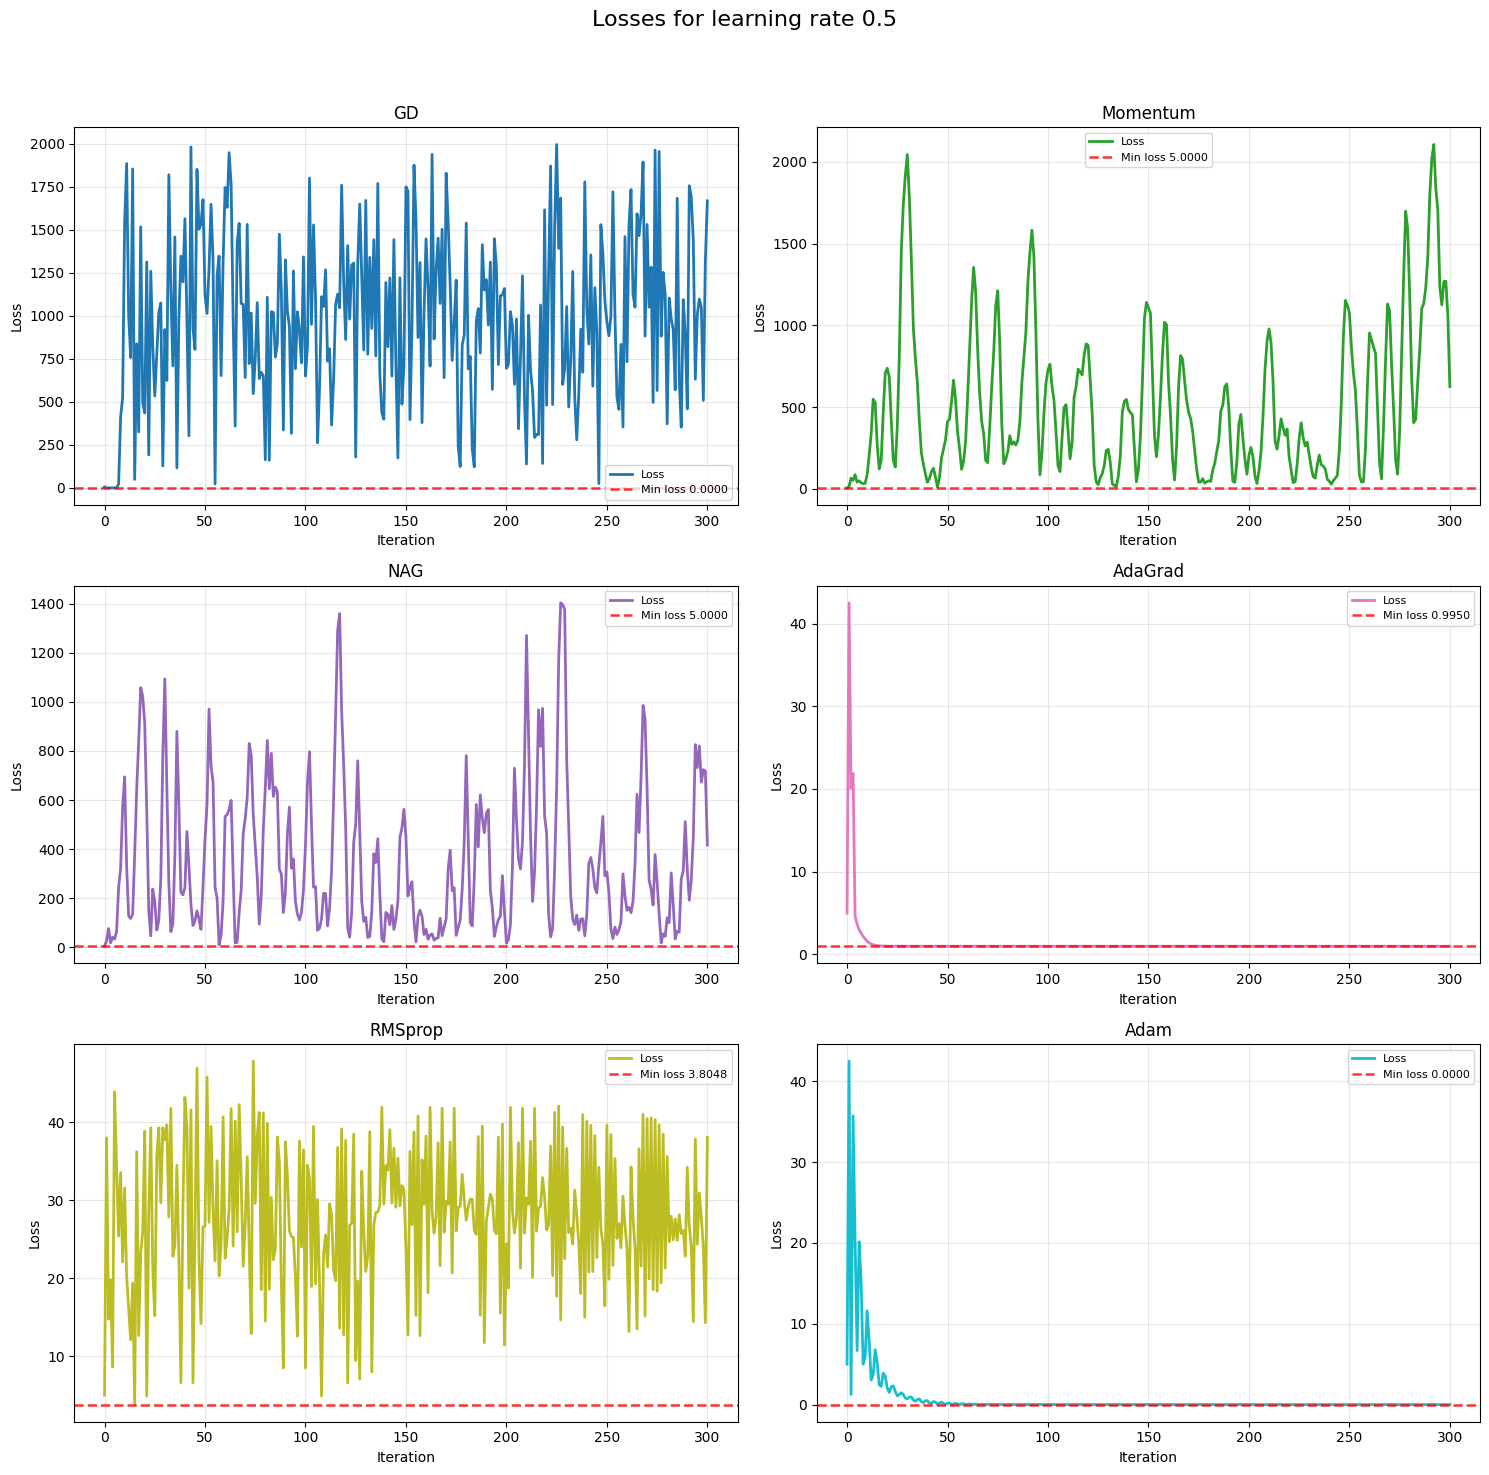

In [ ]:
for lr in [0.01, 0.05, 0.1, 0.5]:
    run_experiment_with_lr(lr)

**Выводы:**
- в глобальный минимум сошелся только Adam при learning rate 0.5
- про высоком learning rate (0.5) AdaGrad сошелся в лучший минимум, но не глобальный минимум
- при увеличении learning rate в данном случае классический градиантный спуск, momentum, NAG, RMSprop сильно ухудшается по лоссу
- learning rate важно подбирать

Еще раз построим визуализацию траекторий

In [70]:
# Параметры
initial_point = np.array([-1.0, 2.0])  # стартовая точка вдали от минимума — не меняем!
n_iter = 300

# Создаём оптимизаторы
optimizers = {
    'GD':       VanillaGD(learning_rate=0.5, n_iterations=n_iter),
    'Momentum': MomentumGD(learning_rate=0.5, n_iterations=n_iter, beta=0.9),
    'NAG':      NesterovGD(learning_rate=0.5, n_iterations=n_iter, beta=0.9),
    'AdaGrad':  AdaGrad(learning_rate=0.5,  n_iterations=n_iter),
    'RMSprop':  RMSprop(learning_rate=0.5,  n_iterations=n_iter, beta=0.9),
    'Adam':     Adam(learning_rate=0.5,     n_iterations=n_iter)
}

# Создаём сетку для визуализации
x_range = np.linspace(-5.5, 5.5, 300)
y_range = np.linspace(-5.5, 5.5, 300)
X, Y = np.meshgrid(x_range, y_range)
Z = np.zeros_like(X)

for i in range(len(x_range)):
    for j in range(len(y_range)):
        Z[j, i] = rastrigin_function(np.array([X[j, i], Y[j, i]]))

# Обучаем все оптимизаторы
results = {}
for name, optimizer in optimizers.items():
    final_params = optimizer.fit(rastrigin_function, rastrigin_gradient, initial_point)
    results[name] = optimizer.history
    print(f"{name:12s}: Final loss = {rastrigin_function(final_params):.6f}, "
          f"Params = [{final_params[0]:.4f}, {final_params[1]:.4f}]")

print(f"\nГлобальный минимум (True): [0, 0]")

# Визуализация траекторий — если вы ничего не меняли в базовом классе — оно просто запустится
fig_opt = go.Figure()

# Контур функции
fig_opt.add_trace(
    go.Contour(
        x=x_range,
        y=y_range,
        z=np.log10(Z + 1),  # лог по (f + 1), чтобы избежать log(0)
        colorscale='Viridis',
        showscale=False,
        contours=dict(start=0, end=3, size=0.1),
        opacity=0.6,
        name='Rastrigin function (log scale)'
    )
)

# Траектории всех оптимизаторов
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink']
for idx, (name, history) in enumerate(results.items()):
    trajectory = np.array(history['params'])
    fig_opt.add_trace(
        go.Scatter(
            x=trajectory[:, 0],
            y=trajectory[:, 1],
            mode='lines',
            line=dict(color=colors[idx], width=2),
            name=name
        )
    )

# Глобальный минимум
fig_opt.add_trace(
    go.Scatter(
        x=[0.0], y=[0.0],
        mode='markers',
        marker=dict(size=15, color='yellow', symbol='star',
                    line=dict(color='black', width=2)),
        name='Глобальный минимум'
    )
)

# Стартовая точка
fig_opt.add_trace(
    go.Scatter(
        x=[initial_point[0]], y=[initial_point[1]],
        mode='markers',
        marker=dict(size=10, color='red', symbol='x'),
        name='Старт'
    )
)

fig_opt.update_layout(
    title="Сравнение оптимизаторов на Rastrigin function",
    xaxis_title="x",
    yaxis_title="y",
    hovermode='closest',
    width=900,
    height=700
)

fig_opt.show()


GD          : Final loss = 1667.287210, Params = [-28.4781, 28.7901]
Momentum    : Final loss = 625.134591, Params = [5.5982, 23.9922]
NAG         : Final loss = 416.778504, Params = [18.2768, 7.3683]
AdaGrad     : Final loss = 0.994959, Params = [-0.0000, 0.9950]
RMSprop     : Final loss = 38.034295, Params = [1.6544, 0.4469]
Adam        : Final loss = 0.000000, Params = [0.0000, -0.0000]

Глобальный минимум (True): [0, 0]


### **Задание 3. Будь выпуклым (3 балла)**



На протяжении курса вы могли заметить, что мы всегда предпочитаем выпуклые функции потерь. Но насколько это требование жесткое? Давайте рассмотрим простейшую логистическую регрессию.

Модель:

$$p(x; w) = \sigma(z) = \sigma(w^\top x), \quad \sigma(z) = \frac{1}{1 + e^{-z}}.$$

Стандартный log-loss для одного объекта:

$$L_{\log}(p, y) = -\big( y \log p + (1-y)\log(1-p)\big), \quad y \in {0, 1}.$$

Рассмотрим для неё модифицированный loss — без логарифма. Просто опустим его, оставив линейную комбинацию вероятностей.

$$L_{\text{no-log}}(p, y) = -\big( y p + (1-y)(1-p)\big)$$


#### **3. 1. Логарифм? (2 балла)**

Попробуем понять, зачем вообще нам нужен логарифм.

1. Выведите производную logloss'a  без логарифма по $p$ **(только по $p$, по $w$ не надо!)**. Что получилось? Подумайте (погуглите), почему на практике используют логарифм.

2. Сравните качество:

   * обучите логистическую регрессию с обычным log-loss,
   * обучите с модифицированным loss без log,
   * сравните качество моделей. Поясните результаты.

  **В функциях градиенты должны быть уже по W**


In [76]:
# Генерация данных
X_class, y_class = make_classification(
    n_samples=1000,
    n_features=30,
    n_informative=20,
    random_state=42
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_class)
X_with_bias = np.column_stack([np.ones(len(X_scaled)), X_scaled])  # добавляем bias-столбец


# Функции для лосса
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


# Стандартный логистический log-loss
def logistic_loss(weights, X, y):
    """
    L_log(w) = - mean( y log p + (1-y) log(1-p) ),  p = sigmoid(X w)
    """
    p = sigmoid(X@weights)
    return - np.mean(y*np.log(p) + (1-y)*np.log(1-p))


def logistic_gradient(weights, X, y):
    """
    grad_w L_log(w) = X^T (p - y) / N,  где p = sigmoid(X w)
    """
    p = sigmoid(X@weights)
    return X.T @ (p-y) / len(y)


def without_log_loss(weights, X, y):
    """
    Log-loss без логарифма"
        L_no_log(w) = - mean( y p + (1 - y)(1 - p) ), p = sigmoid(X w)
    """
    p = sigmoid(X@weights)
    return - np.mean(y*p + (1-y)*(1-p))


def without_log_loss_grad(weights, X, y):
    """
    Градиент L_no_log по w:
        dL/dp = 1 - 2y
        dp/dz = p (1-p)
        z = X w

    grad_w L_no_log = X^T * [ (1 - 2y) * p (1-p) ] / N
    """
    p = sigmoid(X@weights)
    return X.T @ ((1-2*y)*p*(1-p)) / len(y)

Проверим результаты.

* далее везде используйте окласс оптимизатора (`VanillaGD`) и одинаковую инициализацию весов;
* для каждой модели реализуйте свои `loss_fn` и `grad_fn` и передайте их в `fit` через `lambda`:

  ```python
  gd_log = VanillaGD(...)
  w_log = gd_log.fit(
      loss_fn=lambda w: logistic_loss(w, X_with_bias, y),
      grad_fn=lambda w: logistic_gradient(w, X_with_bias, y),
      initial_params=initial_weights
  )
  ```

  и аналогично для `no_log_loss` / `no_log_loss_grad`. Так всё заработает.


In [77]:
initial_weights = np.ones(X_with_bias.shape[1])

# Логистическая регрессия с log-loss
gd_log = VanillaGD(learning_rate=0.5, n_iterations=200)
w_log = gd_log.fit(
    loss_fn=lambda w: logistic_loss(w, X_with_bias, y_class),
    grad_fn=lambda w: logistic_gradient(w, X_with_bias, y_class),
    initial_params=initial_weights
  )

# Логистическая регрессия с no-log loss
gd_no = VanillaGD(learning_rate=0.5, n_iterations=200)
w_no = gd_no.fit(
    loss_fn=lambda w: logistic_loss(w, X_with_bias, y_class),
    grad_fn=lambda w: logistic_gradient(w, X_with_bias, y_class),
    initial_params=initial_weights
  )

def accuracy(weights):
    p = sigmoid(X_with_bias @ weights)
    y_pred = (p >= 0.5).astype(int)
    return (y_pred == y_class).mean()

print("\n=== Итоговые результаты (VanillaGD) ===")
print(f"log-loss:    final_loss = {logistic_loss(w_log, X_with_bias, y_class):.4f}, "
      f"accuracy = {accuracy(w_log):.4f}")
print(f"no-log loss: final_loss = {without_log_loss(w_no, X_with_bias, y_class):.4f}, "
      f"accuracy = {accuracy(w_no):.4f}")



=== Итоговые результаты (VanillaGD) ===
log-loss:    final_loss = 0.3976, accuracy = 0.8110
no-log loss: final_loss = -0.7450, accuracy = 0.8110


#### **3. 2. И снова анализ (1 балл)**

Подумайте над результатами задания.
- Почему no-log выдал меньший loss? Значит ли это, что мы можем его использовать?
- Что будет, если подобрать гиперпараметр скорости спуска и попробовать другие оптимизаторы?

Реализуйте ваши эксперименты. За каждый — 0.5 балла (суммарно максимум 1 балл).

In [94]:
def run_experiment_logloss_nologloss(optimizer_class, lr: float = 0.5, n_iter: int = 200):

    initial_weights = np.ones(X_with_bias.shape[1])

    # Логистическая регрессия с log-loss
    gd_log = optimizer_class(learning_rate=lr, n_iterations=n_iter)
    w_log = gd_log.fit(
        loss_fn=lambda w: logistic_loss(w, X_with_bias, y_class),
        grad_fn=lambda w: logistic_gradient(w, X_with_bias, y_class),
        initial_params=initial_weights
    )

    # Логистическая регрессия с no-log loss
    gd_no = optimizer_class(learning_rate=lr, n_iterations=n_iter)
    w_no = gd_no.fit(
        loss_fn=lambda w: logistic_loss(w, X_with_bias, y_class),
        grad_fn=lambda w: logistic_gradient(w, X_with_bias, y_class),
        initial_params=initial_weights
    )

    def accuracy(weights):
        p = sigmoid(X_with_bias @ weights)
        y_pred = (p >= 0.5).astype(int)
        return (y_pred == y_class).mean()

    print(f"\n=== Итоговые результаты ({optimizer_class.__name__}) ===")
    print(f"log-loss:    final_loss = {logistic_loss(w_log, X_with_bias, y_class):.4f}, "
        f"accuracy = {accuracy(w_log):.4f}")
    print(f"no-log loss: final_loss = {without_log_loss(w_no, X_with_bias, y_class):.4f}, "
        f"accuracy = {accuracy(w_no):.4f}")

In [98]:
for lr in [0.01, 0.05, 0.1, 0.5]:
    run_experiment_logloss_nologloss(VanillaGD, lr)


=== Итоговые результаты (VanillaGD) ===
log-loss:    final_loss = 1.4552, accuracy = 0.6110
no-log loss: final_loss = -0.6049, accuracy = 0.6110

=== Итоговые результаты (VanillaGD) ===
log-loss:    final_loss = 0.6941, accuracy = 0.7150
no-log loss: final_loss = -0.6878, accuracy = 0.7150

=== Итоговые результаты (VanillaGD) ===
log-loss:    final_loss = 0.4714, accuracy = 0.7890
no-log loss: final_loss = -0.7335, accuracy = 0.7890

=== Итоговые результаты (VanillaGD) ===
log-loss:    final_loss = 0.3976, accuracy = 0.8110
no-log loss: final_loss = -0.7450, accuracy = 0.8110


In [100]:
for optimizer in [VanillaGD, MomentumGD, NesterovGD, AdaGrad, RMSprop, Adam]:
    run_experiment_logloss_nologloss(optimizer, 0.1)


=== Итоговые результаты (VanillaGD) ===
log-loss:    final_loss = 0.4714, accuracy = 0.7890
no-log loss: final_loss = -0.7335, accuracy = 0.7890

=== Итоговые результаты (MomentumGD) ===
log-loss:    final_loss = 0.4752, accuracy = 0.7860
no-log loss: final_loss = -0.7356, accuracy = 0.7860

=== Итоговые результаты (NesterovGD) ===
log-loss:    final_loss = 0.4748, accuracy = 0.7870
no-log loss: final_loss = -0.7354, accuracy = 0.7870

=== Итоговые результаты (AdaGrad) ===
log-loss:    final_loss = 0.4030, accuracy = 0.8170
no-log loss: final_loss = -0.7299, accuracy = 0.8170

=== Итоговые результаты (RMSprop) ===
log-loss:    final_loss = 0.4113, accuracy = 0.8150
no-log loss: final_loss = -0.7399, accuracy = 0.8150

=== Итоговые результаты (Adam) ===
log-loss:    final_loss = 0.3975, accuracy = 0.8110
no-log loss: final_loss = -0.7447, accuracy = 0.8110


**Выводы:**
- accuracy для обоих вариантов совпадает
- изменение learning rate или оптимизатора в данном случае одинаков влияет на accuracy для обоих вариантов реализации
- loss для разных вариантов реализации несравним (log-loss положительный), следовательно меньший лосс для другой функции потерь не означает лучшую модель
- на приктике используется log-loss (проще интерпретировать как вероятность, штраф из излишнюю уверенность модели, гладкие функции ведут себя более предсказуемо)

## **Бонус 0.25 балла**

Проанализируйте график лосс-функции ниже. Попробуйте сформулировать гипотезы:
- Что происходит?
- Что с этим делать?


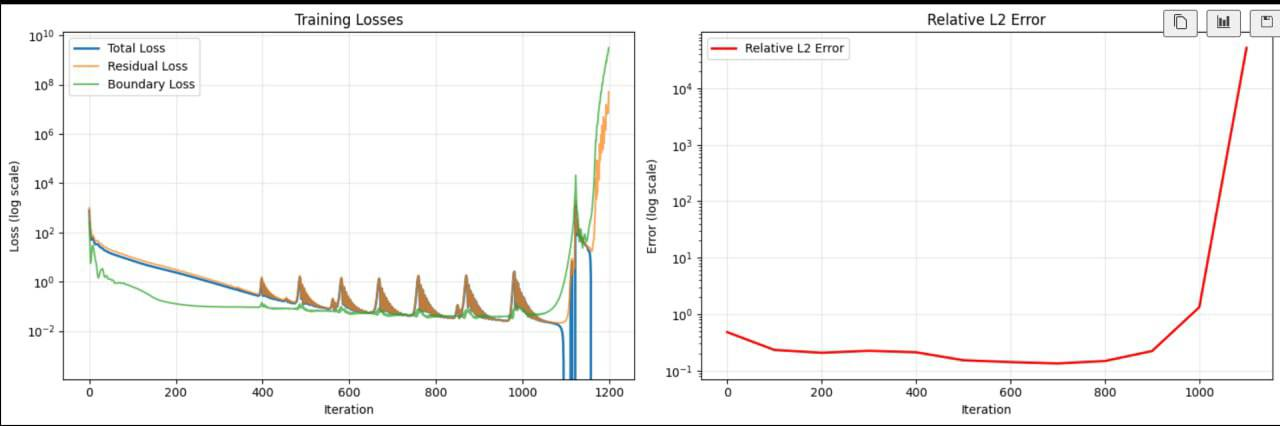

**Выводы:**
- до 400 итерации лосс плавно убывают, далее начинаются скачки
- возможно использовался адаптивный метод, долго шли в одном направлении, накопились скорости/импульсы и куда-то улетали, потом сходились (400 - 1000 итерации)
- в конце сильно улетели от оптимума, метрика тоже ухудшилась, возможно нужна ранняя остановка
- если это RNN или нейронка, то возможно произошел взрыв градиента